## Import


In [2]:
import numpy as np
import pandas as pd

C:\Users\hanne\AppData\Local\Temp\ipykernel_18464\1662815981.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Daten einlesen


In [3]:
col_names = ["contour number", "aspect ratio", "extent", "Blue", "Green", "Red", "Hue"]
data = pd.read_csv("output.csv", index_col=0)
data_burghart = pd.read_csv("output_burghart.csv", index_col=0)
# besser als excel weil csv weniger Metadaten speichert und so bei vielen Bildern Rechenzeit reduziert wird
# data = pd.read_excel("output.xlsx", skiprows=1, header=None, names=col_names)
data.head(30)

,contour number,aspect ratio,extent,Blue,Green,Red,Hue,class
0,16,0.850735,0.762296,83.383101,143.296144,143.572600,38.485644,0
1,25,0.626242,0.763346,76.382386,75.957386,85.665909,150.730682,0
2,31,0.628238,0.695970,60.357078,114.183692,136.153077,15.567445,0
3,31,0.896541,0.800835,44.570000,117.787500,134.971667,17.529167,0
4,63,0.693736,0.824233,36.742411,117.234172,135.391154,17.088465,0
5,34,0.928571,0.808913,46.546503,110.883922,126.844989,18.361932,0
6,68,0.979804,0.836557,63.621205,104.295904,104.446747,29.446747,0
7,51,0.760961,0.823015,59.701164,99.514131,103.025769,32.987531,0
8,31,0.957265,0.767948,50.077372,116.466180,137.658394,22.445255,0
9,50,0.828162,0.845766,60.658955,104.919383,113.961094,34.713985,0


## Klasse für Knoten


In [4]:
class Node:
    def __init__(
        self,
        feature_index=None,
        threshold=None,
        left=None,
        right=None,
        info_gain=None,
        value=None,
    ):
        """constructor"""

        # für decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain

        # für leaf node
        self.value = value

## Klasse für Erstellung des Baumes


In [5]:
class DecisionTreeClassifier:
    def __init__(self, min_samples_split=2, max_depth=2):
        """constructor"""

        # Initialisiere root des decision tree, wird benötigt um tree zu durchlaufen
        self.root = None

        # node wird nicht weiter verästelt wenn:
        self.min_samples_split = min_samples_split  # wenn Anzahl der Samples aus den trainingsdaten im node weniger als dieser wert wird, wird node zu leaf node
        self.max_depth = max_depth  # wenn max anzahl an verketteten Ebenen erreicht ist, wird node zu leaf node

    def build_tree(self, dataset, curr_depth=0):
        """rekursive Funktion um decision tree aufzubauen"""
        # Array an Trainingsdaten wird aufgespalten: Merkmale X werden von Klassenzuordnung Y (letzte Spalte) getrennt
        X, Y = dataset[:, :-1], dataset[:, -1]
        # Abfrage: num_samples= Anzahl Zeilen der features; num_features= Anzahl Spalten der features
        num_samples, num_features = np.shape(X)

        # weiter verästeln, bis Stop-Bedingung
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            # finde beste Aufteilung (maximiere information gain)
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # überprüfe ob information gain positiv, wenn nicht besteht Knoten nur noch aus einer Klasse
            if best_split["info_gain"] > 0:
                # Rekursion für linke Seite des Baumes bis überall leaf nodes
                left_subtree = self.build_tree(
                    best_split["dataset_left"], curr_depth + 1
                )
                # Rekursion für rechte Seite
                right_subtree = self.build_tree(
                    best_split["dataset_right"], curr_depth + 1
                )
                # gebe decision node zurück
                return Node(
                    best_split["feature_index"],
                    best_split["threshold"],
                    left_subtree,
                    right_subtree,
                    best_split["info_gain"],
                )

        # berechne leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # gebe leaf node zurück
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        """function to find the best split"""

        # dictionary um beste Teilung zu speichern
        best_split = {}
        max_info_gain = -float("inf")

        # Durch alle Merkmale iterieren
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # iterieren durch alle Merkmalswerte im Datensatz
            for threshold in possible_thresholds:
                # Teilung berechnen
                dataset_left, dataset_right = self.split(
                    dataset, feature_index, threshold
                )
                # resultierende Datasets dürfen nicht 0 sein
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    # Extrahieren der Klassen aus dem übrig gegbliebenen dataset
                    y, left_y, right_y = (
                        dataset[:, -1],
                        dataset_left[:, -1],
                        dataset_right[:, -1],
                    )
                    # Berechnung information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # Aktualisieren der besten Teilung wenn gain größer ist als aktuelles maximun
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        # Beste Teilung zurück geben
        return best_split

    def split(self, dataset, feature_index, threshold):
        """function to split the data"""

        dataset_left = np.array(
            [row for row in dataset if row[feature_index] <= threshold]
        )
        dataset_right = np.array(
            [row for row in dataset if row[feature_index] > threshold]
        )
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        """function to compute information gain"""

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == "gini":
            gain = self.gini_index(parent) - (
                weight_l * self.gini_index(l_child)
                + weight_r * self.gini_index(r_child)
            )
        else:
            gain = self.entropy(parent) - (
                weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child)
            )
        return gain

    def entropy(self, y):
        """function to compute entropy"""

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):
        """function to compute gini index"""

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

    def calculate_leaf_value(self, Y):
        """function to compute leaf node"""

        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):
        """function to print the tree"""

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print(
                "X_" + str(tree.feature_index),
                "<=",
                tree.threshold,
                "?",
                tree.info_gain,
            )
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        """function to train the tree"""

        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        """function to predict new dataset"""

        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions

    def make_prediction(self, x, tree):
        """function to predict a single data point"""

        if tree.value != None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

## Aufteilung der Daten in Trainings- und Testdaten


In [6]:
X = data.iloc[
    :, :-1
].values  # erstes ":" für alle Zeilen, nach dem Komma ":-1" = "alle Spalten bis auf die letzte", Bildung np-Array durch ".values"
Y = data.iloc[:, -1].values.reshape(
    -1, 1
)  # nur letzte Spalte. "reshape" konvertiert Vektor in Spaltenvektor mit 1 Spalte. durch "-1" werden Zeilen automatisch berechnet

###---------------------------------------------------------------------------------------------------------------------------------------
X_burghart_test = data_burghart.iloc[
    :, :-1
].values 
Y_burghart_test = data_burghart.iloc[:, -1].values.reshape(
    -1, 1
)
###---------------------------------------------------------------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split

# Aufteilen der Daten in Trainings-und Testdaten
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=41
)

## Modell trainieren


In [7]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train, Y_train)
classifier.print_tree()

X_1 <= 0.3878309609528353 ? 0.21996709775239248
 left:X_1 <= 0.2934350349753082 ? 0.02542858571753752
  left:X_6 <= 51.897590361445786 ? 0.004236010507498167
    left:X_4 <= 196.23 ? 0.0038090011391582693
        left:1.0
        right:0.0
    right:X_0 <= 68.0 ? 0.38888888888888895
        left:0.0
        right:1.0
  right:X_5 <= 126.17891373801918 ? 0.1258574455774102
    left:X_6 <= 13.82089552238806 ? 0.08012989354254907
        left:1.0
        right:2.0
    right:X_0 <= 26.0 ? 0.09025540040577638
        left:0.0
        right:1.0
 right:X_6 <= 13.267813267813269 ? 0.07926817188679458
  left:X_0 <= 55.0 ? 0.03637760665865902
    left:X_3 <= 37.92910447761194 ? 0.023068439143597297
        left:0.0
        right:0.0
    right:X_6 <= 11.575757575757576 ? 0.20663265306122458
        left:1.0
        right:2.0
  right:X_6 <= 25.13830755232029 ? 0.05763471412087967
    left:X_3 <= 43.22510822510822 ? 0.027708251748383927
        left:2.0
        right:2.0
    right:X_0 <= 88.0 ? 0.16

## Modell testen


In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Vorhersagen der Klassen mit dem Testdatensatz
Y_pred = classifier.predict(X_test)
Y_burghart_pred = classifier.predict(X_burghart_test)

# Ausgabe der Genauigkeit
print("accuracy score:          ", accuracy_score(Y_test, Y_pred))
print("accuracy score burghart: ", accuracy_score(Y_burghart_test, Y_burghart_pred))

# Ausgabe der Konfusion Matrix 
print('\nconfusion matrix:')
print(confusion_matrix(Y_test, Y_pred),'\n')

# Ausgabe des Classifikation Report
print(classification_report(Y_test, Y_pred))

# Precision = Prozentsatz der korrekt positiven Vorhersagen zu allen positiven Vorhersagen  (True Positives/ all predicted Positives)
# recall    = Prozentsatz der korrekt positiven Vorhersagen zu allen tatsächlich Positiven  (True Positives/ all real Positives)
# f1-score  = Mittelwert aus Precision und Recall  

accuracy score:           0.7265861027190332
accuracy score burghart:  0.6190476190476191

confusion matrix:
[[ 68   7 147]
 [  2 143   9]
 [ 11   5 270]] 

              precision    recall  f1-score   support

           0       0.84      0.31      0.45       222
           1       0.92      0.93      0.93       154
           2       0.63      0.94      0.76       286

    accuracy                           0.73       662
   macro avg       0.80      0.73      0.71       662
weighted avg       0.77      0.73      0.69       662



### Vergleich mit Modell aus sklearn


Accuracy skLearn: 0.7854984894259819


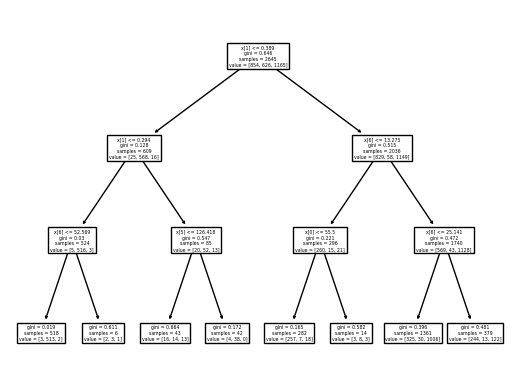

In [33]:
from sklearn import tree
from sklearn.metrics import accuracy_score

DTmodel_sklearn = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
DTmodel_sklearn.fit(X_train,Y_train)

tree.plot_tree(DTmodel_sklearn)

# Vorhersagen der Klassen mit dem Testdatensatz
Y_pred = DTmodel_sklearn.predict(X_test)

# Ausgabe der Genauigkeit
accuracy_skl = accuracy_score(Y_test, Y_pred)
print("Accuracy skLearn:", accuracy_skl)